In [1]:
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import multivariate_normal as smn
#from jax.scipy.stats import multivariate_normal as jmn
#from jax import random
import scipy

import jax.numpy as jnp

In [27]:
def f(t,t0,sig,P,k):
    return k*jnp.exp(-(t-t0)**2/(2*sig**2))*jnp.sin(2*jnp.pi*t/P)

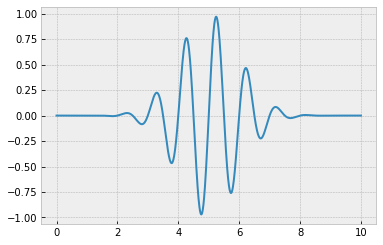

In [44]:
t=jnp.linspace(0,10.0,1000)
plt.plot(t,f(t,5.0,1.0,1.0,1.0))

In [45]:
def RBF(t,tau):
    Dt = t - np.array([t]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

def Matern32(t,tau):
    Dt = t - np.array([t]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [46]:
np.random.seed(seed=1)
N = 256
t = np.linspace(0,10,N)
ave = np.zeros(N)
tau = 0.4
a=1.0
t0_in=5.0
sig_in=1.0
P_in=1.0
k_in=10.0
ave = f(t,t0_in,sig_in,P_in,k_in)
cov = a*RBF(t,tau) #cov = Matern32(t,tau)
di = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
sigma=0.6
d=di+np.random.normal(0.0,sigma,len(di))

Text(0.5, 0, 't')

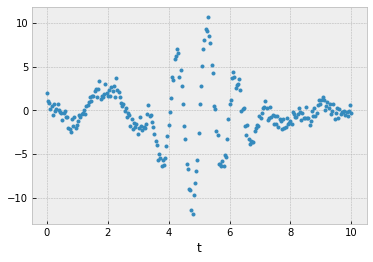

In [47]:
import seaborn as sns
plt.style.use('bmh')
plt.plot(t,d,".")
plt.xlabel("t")

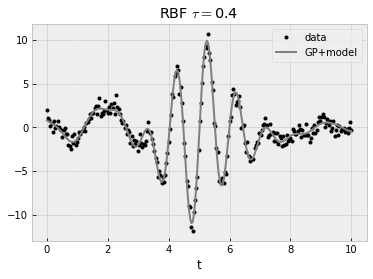

In [50]:



#cov@Pid@d
plt.plot(t,d,".",color="black",label="data")
plt.plot(t,di,color="gray",label="GP+model")
plt.xlabel("t")
plt.title("RBF $\\tau=$"+str(tau))
plt.legend()
plt.savefig("gp1.pdf")

In [51]:
def modelcov(t,tau,a,sigma):
    Dt = t - jnp.array([t]).T
    K=a*jnp.exp(-(Dt)**2/2/(tau**2))+jnp.exp(jnp.eye(N)*sigma**2)
    return K

In [52]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(t,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    tau = numpyro.sample('tau', dist.Exponential(1.))
    a = numpyro.sample('a', dist.Exponential(1.))
    cov = modelcov(t,tau,a,sigma)
    
    t0=numpyro.sample("t0",dist.Uniform(4.5,5.5))
    s=numpyro.sample('s', dist.Exponential(1.))
    P=numpyro.sample('P', dist.Exponential(1.))
    k=numpyro.sample('k', dist.Exponential(0.2))
    ave = f(t,t0,s,P,k)
    numpyro.sample('y', dist.MultivariateNormal(loc=ave, covariance_matrix=cov), obs=y)

In [54]:
from numpyro.infer import MCMC, NUTS
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples =num_samples)
mcmc.run(rng_key_, t=t, y=d)
mcmc.print_summary()

sample: 100%|█████████████████████████████| 3000/3000 [00:50<00:00, 59.53it/s, 7 steps of size 3.47e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         P      1.25      0.01      1.25      1.24      1.27   1478.01      1.00
         a      5.14      1.30      4.98      3.01      7.10   1464.96      1.00
         k     13.95      1.59     13.93     11.40     16.50   1378.75      1.00
         s      0.53      0.05      0.53      0.45      0.61   1529.59      1.00
     sigma      0.54      0.02      0.54      0.51      0.58   1846.53      1.00
        t0      5.01      0.10      5.01      4.84      5.17   1618.63      1.00
       tau      0.28      0.02      0.28      0.24      0.32   1248.14      1.00

Number of divergences: 0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fedbd2a7400>,
      dtype=object)

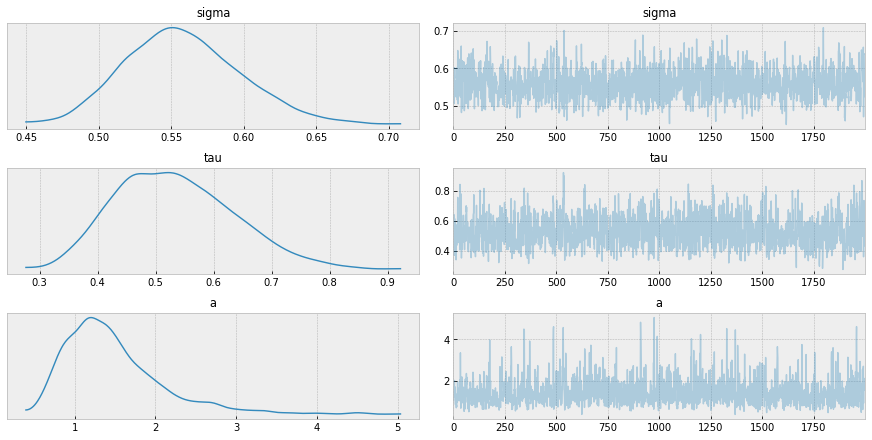

In [148]:
import arviz
arviz.plot_trace(mcmc, var_names=["sigma","tau","a"])
#plt.savefig("gp1.pdf")

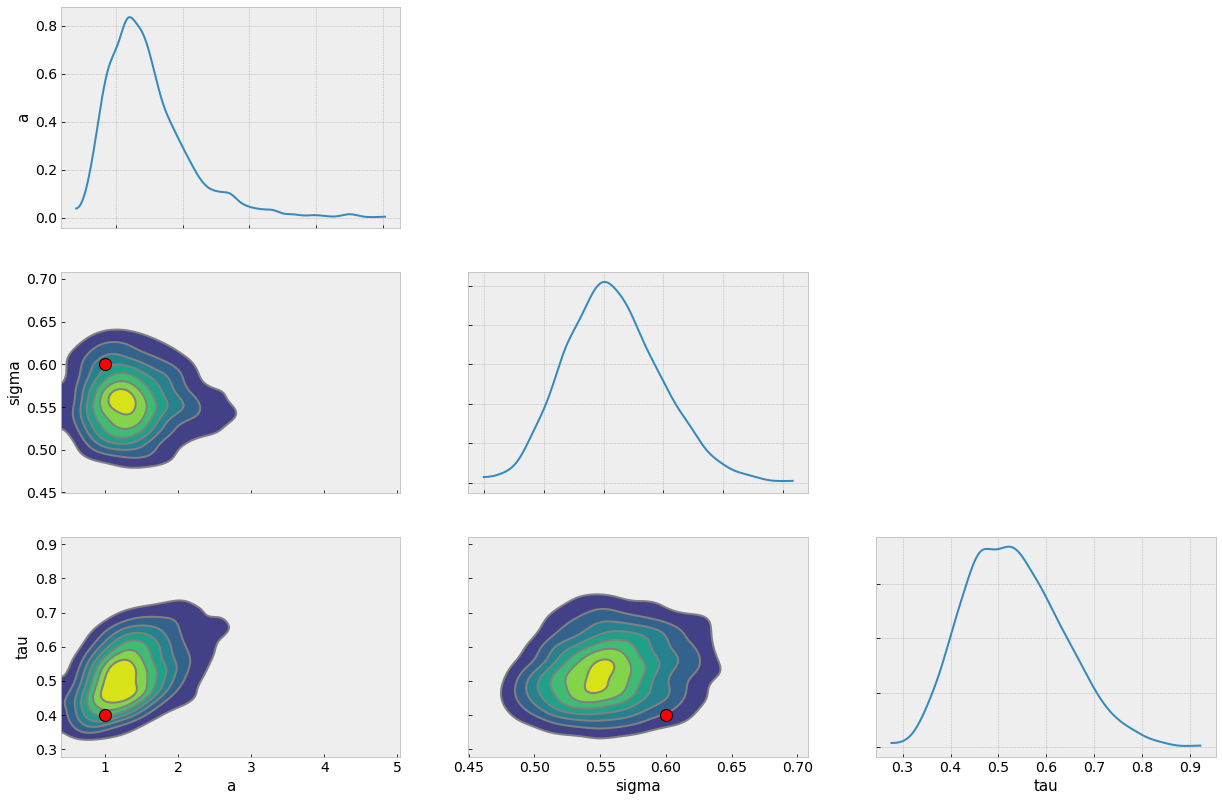

In [149]:
refs={};refs["sigma"]=sigma;refs["tau"]=tau;refs["a"]=a
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("gp2.pdf", bbox_inches="tight", pad_inches=0.0)

In [55]:
posterior_a = mcmc.get_samples()['a']
posterior_tau = mcmc.get_samples()['tau']
posterior_sigma = mcmc.get_samples()['sigma']
posterior_t0 = mcmc.get_samples()['t0']
posterior_s = mcmc.get_samples()['s']
posterior_P = mcmc.get_samples()['P']
posterior_k = mcmc.get_samples()['k']

In [56]:
np.mean(posterior_tau)

DeviceArray(0.28293654, dtype=float32)

In [58]:
from numpyro.infer import Predictive


pred = Predictive(model,{'a':posterior_a,'tau':posterior_tau,'sigma':posterior_sigma,\
                        't0':posterior_t0,'s':posterior_s,'P':posterior_P,'k':posterior_k},return_sites=["y"])
predictions = pred(rng_key_,t=t,y=None)

In [59]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

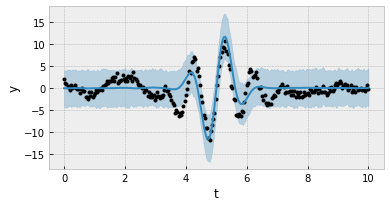

In [60]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(t,d,".",color="black")
ax.plot(t,mean_muy,color="C0")
ax.fill_between(t, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("gp3.pdf")

In [155]:
def muGP(tau,a,sigma):
    cov = a*RBF(t,tau)
    IKw=sigma**2*np.eye(N)+cov
    A=scipy.linalg.solve(IKw,d,assume_a="pos")
    return cov@A

In [156]:
def covGP(tau,a,sigma):
    cov = a*RBF(t,tau)
    IKw=np.eye(N)+cov/sigma**2
    IKw=scipy.linalg.inv(IKw)
    return cov@IKw

In [157]:
import tqdm
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marr=[]
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    ave=muGP(taus,a_s,sigmas)
    cov=covGP(taus,a_s,sigmas)
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marr.append(mk)
marr=np.array(marr)

100%|██████████| 2000/2000 [00:50<00:00, 39.73it/s]


In [158]:
mean_muy = np.mean(marr, axis=0)
hpdi_muy = hpdi(marr, 0.9)

In [159]:
tau,sigma

(0.4, 0.6)

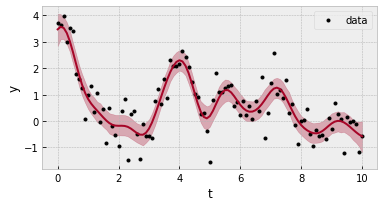

In [160]:
fig=plt.figure(figsize=(6,3 ))
ax=fig.add_subplot(111)
ax.plot(t,d,".",color="black",label="data")
ax.plot(t, mean_muy,color="C1")
ax.fill_between(t, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp4.pdf")

In [90]:
def RBFx(t,td,tau):
    Dt = t - np.array([td]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

def Matern32x(t,td,tau):
    Dt = t - np.array([td]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [91]:
def mucovGPx(t,td,tau,a,sigma,t0,sig,P,k):
    cov = a*RBF(t,tau) + sigma**2*np.eye(N)
    covx= a*RBFx(t,td,tau)
    covxx = a*RBF(td,tau) # + sigma**2*np.eye(N)
    IKw=cov 
    A=scipy.linalg.solve(IKw,d-f(t,t0,sig,P,k),assume_a="pos")
    IKw = scipy.linalg.inv(IKw)
    return f(td,t0,sig,P,k)+covx@A,covxx - covx@IKw@covx.T

In [92]:
import tqdm
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marr=[]
td=np.linspace(-3,13,256)
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    t0_s=float(posterior_t0[i])
    s_s=float(posterior_s[i])
    P_s=float(posterior_P[i])
    k_s=float(posterior_k[i])
    ave,cov=mucovGPx(t,td,tau,a_s,sigma,t0_s,s_s,P_s,k_s)
    
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marr.append(mk)
marr=np.array(marr)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:31<00:00,  7.36it/s]


In [93]:
mean_muy = np.mean(marr, axis=0)
hpdi_muy = hpdi(marr, 0.9)

In [94]:
 list(map(int,np.random.random(10)*len(td)))

[209, 45, 214, 228, 23, 207, 10, 216, 209, 41]

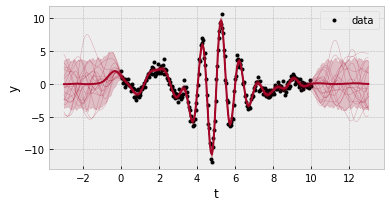

In [95]:
fig=plt.figure(figsize=(6,3 ))
ax=fig.add_subplot(111)
ax.plot(t,d,".",color="black",label="data")
#mu,cov=mucovGPx(t,t,tau,sigma)
#ax.plot(t,mu)
ax.plot(td, mean_muy,color="C1")
ax.fill_between(td, hpdi_muy[0], hpdi_muy[1], alpha=0.2, interpolate=True,color="C1")
for i in list(map(int,np.random.random(20)*len(td))):
    plt.plot(td,marr[i,:],lw=0.5,alpha=0.3,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp5.pdf")

In [85]:
from jax import jit
#@jit
def mucovGPxs(t,td,tau,a,sigma,t0,sig,P,k):
    cov = a*RBF(t,tau) + sigma**2*np.eye(N)
    covx= a*RBFx(t,td,tau)
    covxx = a*RBF(td,tau) + sigma**2*np.eye(N)
    IKw=cov 
    A=jnp.linalg.solve(IKw,d-f(t,t0,sig,P,k))#,assume_a="pos")
    IKw = jnp.linalg.inv(IKw)
    return f(td,t0,sig,P,k)+covx@A,covxx - covx@IKw@covx.T

In [86]:
N

256

In [87]:
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marrs=[]
td=np.linspace(-3,13,256)
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    t0_s=float(posterior_t0[i])
    s_s=float(posterior_s[i])
    P_s=float(posterior_P[i])
    k_s=float(posterior_k[i])
    ave,cov=mucovGPxs(t,td,tau,a_s,sigma,t0_s,s_s,P_s,k_s)
    
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marrs.append(mk)
marrs=np.array(marrs)

mean_muys = np.mean(marrs, axis=0)
hpdi_muys = hpdi(marrs, 0.9)

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]/home/kawahara/anaconda3/lib/python3.8/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:49<00:00,  8.72it/s]


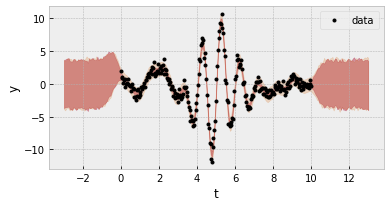

In [96]:
fig=plt.figure(figsize=(6,3 ))
ax=fig.add_subplot(111)

#mu,cov=mucovGPx(t,t,tau,sigma)
#ax.plot(t,mu)
#ax.plot(td, mean_muy,color="C1")
ax.fill_between(td, hpdi_muy[0], hpdi_muy[1], alpha=0.4, interpolate=True,color="C1")
#ax.plot(td, mean_muys,color="red")
ax.fill_between(td, hpdi_muys[0], hpdi_muys[1], alpha=0.2, interpolate=True,color="C4")
ax.plot(t,d,".",color="black",label="data")
#for i in list(map(int,np.random.random(20)*len(td))):
#    plt.plot(td,marr[i,:],lw=0.5,alpha=0.3,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp6.pdf")

In [75]:
len(t)

256